# Set up

In [31]:
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import statsmodels.api as sm
from statsmodels.api import OLS

# BlackBoxAuditing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
lc_census_merged14 = pd.read_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', dtype={'zip_3':str})
all_loans_2014 = pd.read_csv('../hugo/all_loans_2014', dtype={'ZIP':str}, low_memory = False)
all_loans_2015 = pd.read_csv('../hugo/all_loans_2015', dtype={'ZIP':str}, low_memory = False)
census = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})
loans_bought14 = pd.read_csv('../hugo/loans_bought_2014', dtype={'ZIP':str}, header=1)

In [3]:
all_loans_2014_merged = all_loans_2014.merge(census, "left", left_on="ZIP", right_on="zip_3")
all_loans_2015_merged = all_loans_2015.merge(census, "left", left_on="ZIP", right_on="zip_3")

# What variables should we care about?

[Legally protected classes](https://content.next.westlaw.com/Document/Ibb0a38daef0511e28578f7ccc38dcbee/View/FullText.html?contextData=sc.Default&transitionType=Default&firstPage=true&bhcp=1):
* Race
* Color
* Religion or creed
* National origin or ancestry
* Sex
* Age
* Physical or mental disability
* Veteran status
* Genetic information
* Citizenship

Characteristics that are protected by being an Equal Housing Lender, which Lending Club is:
* Race
* Color
* Religion
* National origin
* Sex
* Handicap
* Familial status

Other variables research suggests is correlated to socioeconomic status and other important socio-political outcomes:
* **Education**
* Unemployment
* Poverty
* Income/wealth

<hr>
Variables we have through Lending Club (individual-level fairness):
* Income (`annual_inc_joint`, `annualInc`)
* Loan description (could be used to back out loans for families, for instance) (`desc`)
    * This is something we'd need text analysis for, probably beyond our scope
* Debt-to-income ratio (`dti`)
* Number of mortgage accounts (could be used to back out loans for families) (`mortAcc`)
* Job description (`emp_title`)

Variables that we have through the Census (group-level fairness): 
* Race
* Education
* Family status
* Gender x age
* Unemployment rate
* Workforce
* Household income

<hr>

Synthesizing, it seems like these are our best options for proceeding:

| Type | Features |
| --- | --- |
| Individual-level fairness | *Income* |
| Group-level fairness | *Race, family status, education, unemployment* |

Will consider both **post-hoc** adjustments to achieve fairness (statistical/conditional parity, calibration/predictive equality) and **built-in** fairness features (adjusting the loss function to balance loss by a group of interest).

# Individual-level fairness

* just using reject data, see if people in same zip codes with different dti, risk scores, employment lengths are rejected differently
* histograms for dti and risk score and bar charts for employment

Going to need more full data set to do this, not the scaled back one we have here (i.e., all columns).

# Group-level fairness

First just look at distribution of scores among different quantiles of different demographics.

In [4]:
def plot_proba_distr_quantiles(feature, proba, label, ax):
    tiles = np.percentile(feature.dropna(), [0,25,50,75,100])
    _0_25 = feature < tiles[1]
    _25_50 = (feature < tiles[2]) & (feature > tiles[1])
    _50_75 = (feature < tiles[3]) & (feature > tiles[2])
    _75_100 = (feature < tiles[4]) & (feature > tiles[3])

    sns.kdeplot(proba[_0_25==True].dropna(), color="green", label="0-25", alpha=0.5, ax=ax)
    sns.kdeplot(proba[_25_50==True].dropna(), color="purple", label="25-50", alpha=0.5, ax=ax)
    sns.kdeplot(proba[_50_75==True].dropna(), color="orange", label="50-75", alpha=0.5, ax=ax)
    sns.kdeplot(proba[_75_100==True].dropna(), color="blue", label="75-100", alpha=0.5, ax=ax)
    ax.set_xlabel(label, fontsize=15)
    ax.legend(fontsize=15)

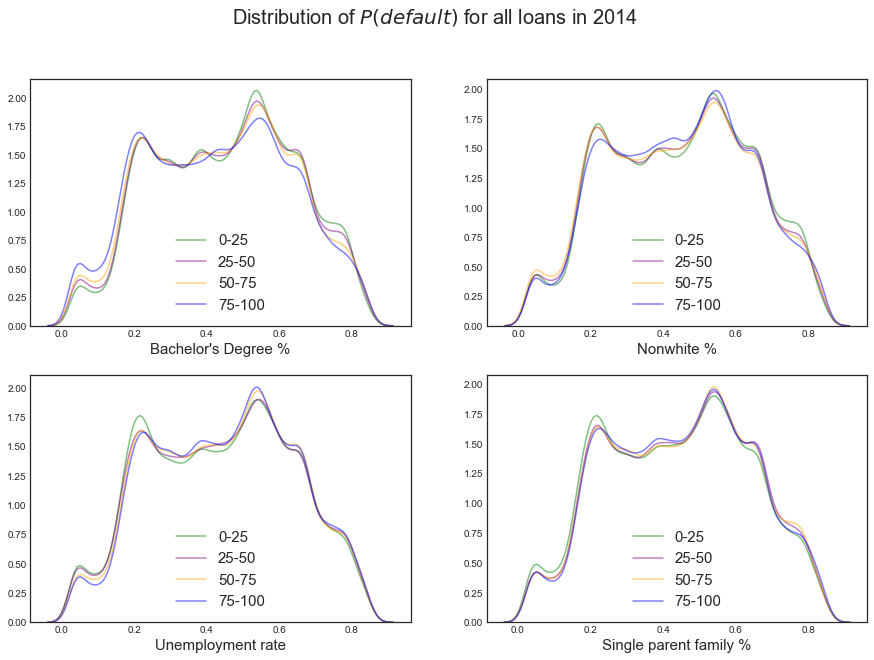

In [5]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_proba_distr_quantiles(all_loans_2014_merged.Bachelors_Degree_pct, all_loans_2014_merged.proba, "Bachelor's Degree %", ax[0,0])
plot_proba_distr_quantiles(all_loans_2014_merged.nonwhite_pct, all_loans_2014_merged.proba, "Nonwhite %", ax[0,1])
plot_proba_distr_quantiles(all_loans_2014_merged.Unemployment_Rate_pct, all_loans_2014_merged.proba, "Unemployment rate", ax[1,0])
plot_proba_distr_quantiles(all_loans_2014_merged.Single_parent_families, all_loans_2014_merged.proba, "Single parent family %", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in 2014", fontsize=20)
plt.show()

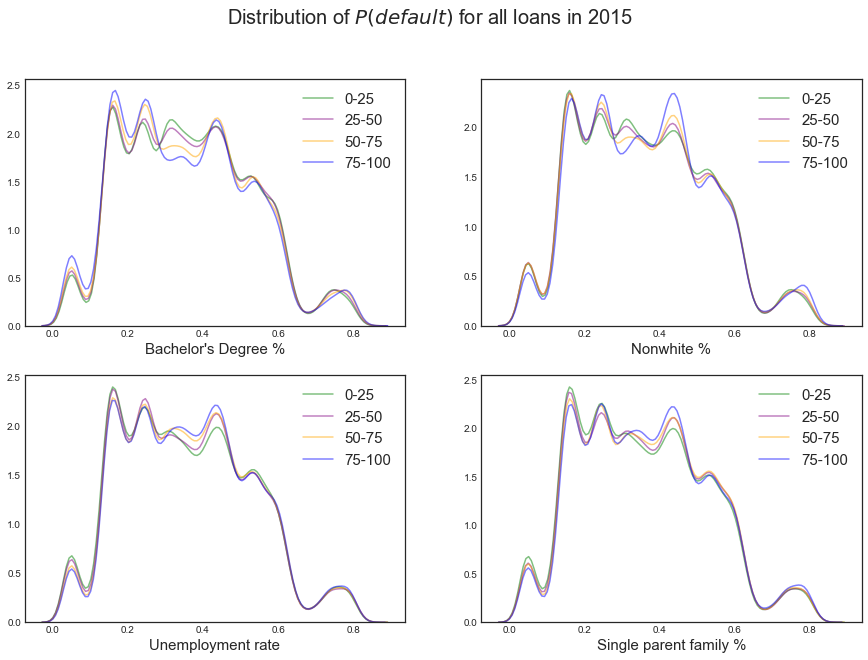

In [6]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_proba_distr_quantiles(all_loans_2015_merged.Bachelors_Degree_pct, all_loans_2015_merged.proba, "Bachelor's Degree %", ax[0,0])
plot_proba_distr_quantiles(all_loans_2015_merged.nonwhite_pct, all_loans_2015_merged.proba, "Nonwhite %", ax[0,1])
plot_proba_distr_quantiles(all_loans_2015_merged.Unemployment_Rate_pct, all_loans_2015_merged.proba, "Unemployment rate", ax[1,0])
plot_proba_distr_quantiles(all_loans_2015_merged.Single_parent_families, all_loans_2015_merged.proba, "Single parent family %", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in 2015", fontsize=20)
plt.show()

Now going to want to use selected subset and count number of loans we choose to invest in by zip code and compare that to the number of loan applications received in that zip code.

In [7]:
num_loans_invested_zip14 = loans_bought14.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()
num_loans_total_zip14 = all_loans_2014_merged.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()

In [8]:
loans14 = num_loans_invested_zip14.merge(num_loans_total_zip14, 'left', left_on='ZIP', right_on='ZIP')

In [9]:
loans14.columns = ['ZIP', 'invest', 'total_approved']

In [10]:
loans14['pct_invested'] = loans14.invest/loans14.total_approved

In [11]:
loans_approved_invested14 = loans14.merge(lc_census_merged14, 'left', left_on='ZIP', right_on='zip_3')

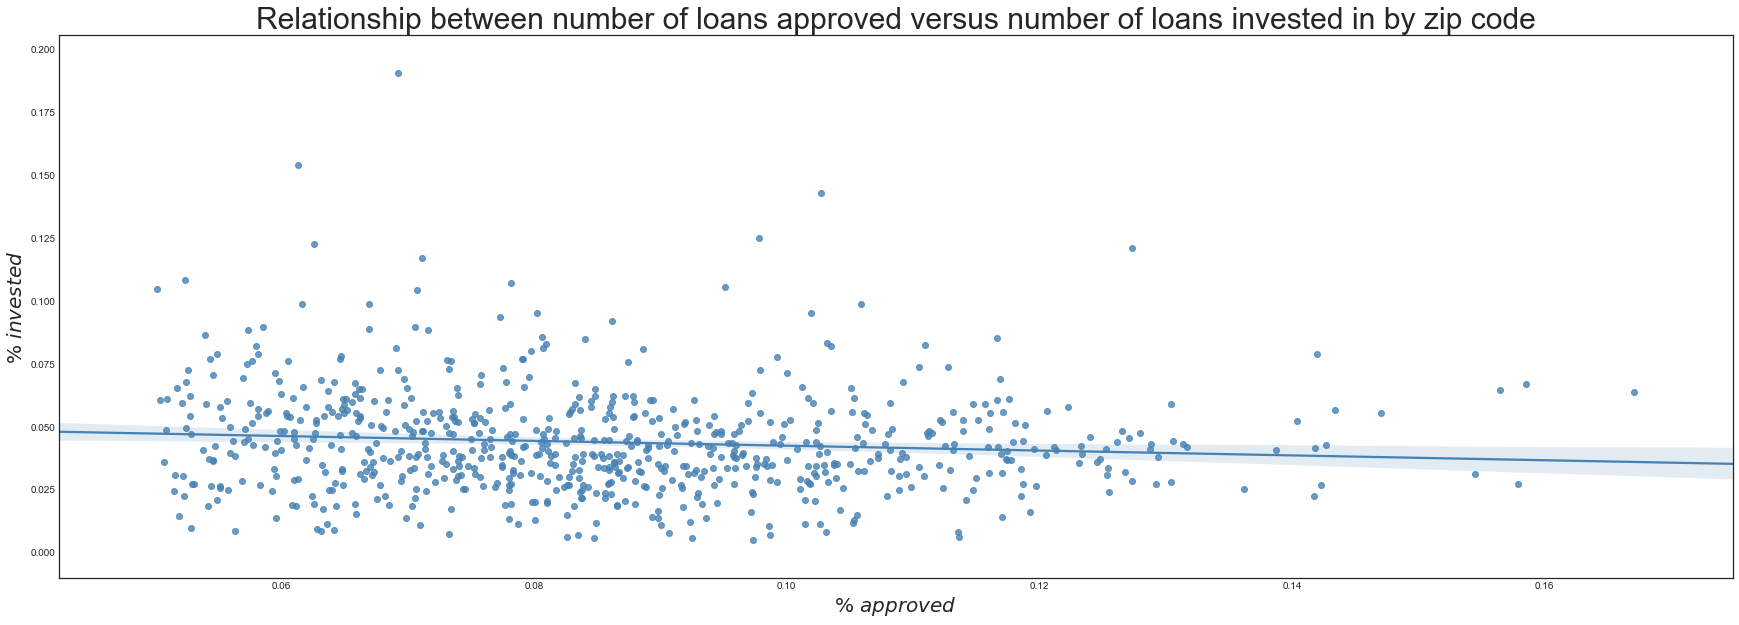

In [12]:
plt.figure(figsize=(30,10))
# plt.scatter(loans_approved_invested14.pct_accepted[loans_approved_invested14.num_loan_apps_considered > 200], 
#             loans_approved_invested14.pct_invested[loans_approved_invested14.num_loan_apps_considered > 200])
sns.regplot(loans_approved_invested14.pct_accepted[loans_approved_invested14.pct_accepted > 0.05], 
            loans_approved_invested14.pct_invested[loans_approved_invested14.pct_accepted > 0.05], color="steelblue")
plt.xlabel(r'$\%\ approved$', fontsize=20)
plt.ylabel(r'$\%\ invested$', fontsize=20)
plt.title('Relationship between number of loans approved versus number of loans invested in by zip code', fontsize=30)
plt.show()

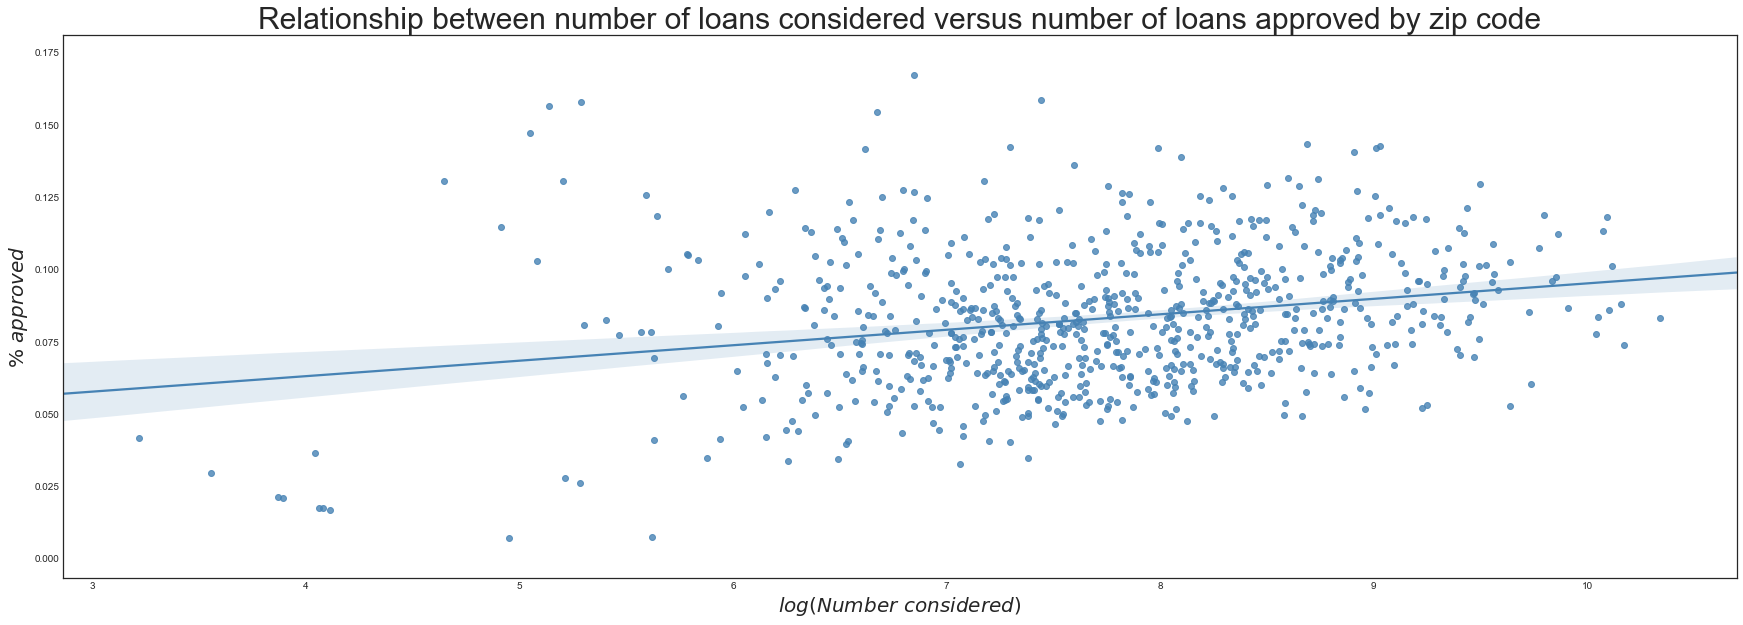

In [13]:
plt.figure(figsize=(30,10))
sns.regplot(np.log(loans_approved_invested14.num_loan_apps_considered), loans_approved_invested14.pct_accepted, 
            color="steelblue")
plt.xlabel(r'$log(Number\ considered)$', fontsize=20)
plt.ylabel(r'$\%\ approved$', fontsize=20)
plt.title('Relationship between number of loans considered versus number of loans approved by zip code', fontsize=30)
plt.show()

# Fairness models

Includes themis-ml, AIF360 and also post-checks from LIME and QII. Will focus more on AIF360 here.

In [14]:
# Disparate impact remover
# running through their example code 1st
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [18]:
from aif360.datasets import AdultDataset

In [19]:
protected = 'sex'
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [23]:
scaler = MinMaxScaler(copy=False)
train, test = ad.split([32561])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

In [32]:
warnings.filterwarnings('ignore', category=UserWarning)
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(solver='lbfgs', class_weight='balanced')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

  0%|          | 0/11 [00:00<?, ?it/s]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  9%|▉         | 1/11 [00:04<00:43,  4.39s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
 18%|█▊        | 2/11 [00:08<00:39,  4.39s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
 27%|██▋       | 3/11 [00:13<00:34,  4.34s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' 

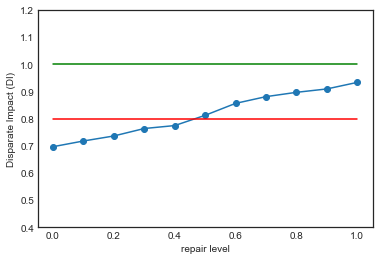

In [35]:
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [38]:
# data is np arrays of shape (rows, cols)
# unsure the type of train

(32561, 5)

In [40]:
DisparateImpactRemover()

aif360.algorithms.preprocessing.disparate_impact_remover.DisparateImpactRemover